# Axial stressed beam

This example is a simple beam, restrained at one side and stressed by a traction load F at the other side.

The geometry is supposed to be deterministic: the diameter D is fixed to D=20 mm.

It is considered that failure occurs when the beam plastifies, i.e. when the axial stress gets bigger than the yield stress:
$$\sigma_e = \frac{F}{\pi-D^2/4} \leq 0$$

Therefore, the state limit G used here is:
$$G = \sigma_e - \frac{F}{\pi-D^2/4}$$

Two independent random variables R and S are considered:

 - R (the strength): $$R = \sigma_e$$
 - S (the load): $$S = \frac{F}{\pi-D^2/4}$$

Stochastic model:

 - F ~ Normal(75e3, 5e3) [N]
 - R ~ LogNormal(300, 30) [N]

Theoretical results:

This two dimensional stochastic problem can be solved by calculating directly the failure probability: 

$$P_f = \text{Prob}(R-S \leq 0) = \int_{r-s \leq 0} f_{R, S}(r, s)drds$$

If R and S are independant, then: 

$$\int_{-\infty}^{+\infty}f_S(x)F_R(x)dx$$

The numerical application gives: $$P_f = 0.0292$$

In [19]:
from __future__ import print_function

import openturns as ot

# dimension
dim = 2

# Analytical model definition:
limitState = ot.NumericalMathFunction(['R', 'F'], ['G'], ['R-F/(_pi*100.0)'])

# Test of the limit state function:
x = [300., 75000.]
print('x=', x)
print('G(x)=', limitState(x))


x= [300.0, 75000.0]
G(x)= [61.2676]


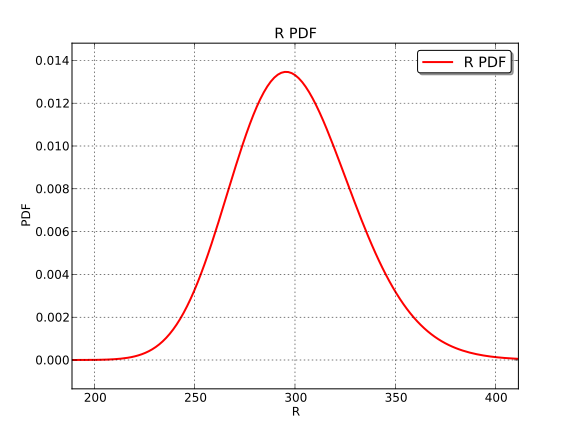

In [20]:
# Stochastic model definition

# Create a first marginal : LogNormal distribution 1D, parameterized by
# its mean and standard deviation
R_dist = ot.LogNormal(300., 30., 0., ot.LogNormal.MUSIGMA)
R_dist.setName('Yield strength')
R_dist.setDescription('R')
# Graphical output of the PDF
R_dist.drawPDF()

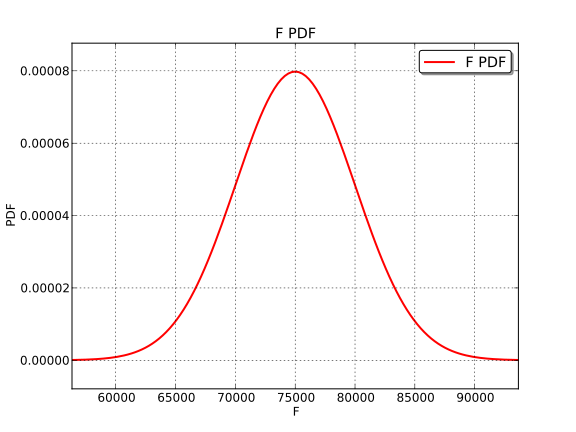

In [21]:
# Create a second marginal : Normal distribution 1D
F_dist = ot.Normal(75000., 5000.)
F_dist.setName('Traction_load')
F_dist.setDescription('F')
# Graphical output of the PDF
F_dist.drawPDF()

In [22]:
# Create a copula : IndependentCopula (no correlation)
aCopula = ot.IndependentCopula(dim)
aCopula.setName('Independent copula')

# Instanciate one distribution object
myDistribution = ot.ComposedDistribution([R_dist, F_dist], aCopula)
myDistribution.setName('myDist')

# We create a 'usual' RandomVector from the Distribution
vect = ot.RandomVector(myDistribution)

# We create a composite random vector
G = ot.RandomVector(limitState, vect)

# We create an Event from this RandomVector
myEvent = ot.Event(G, ot.Less(), 0.0)


MonteCarlo result= probabilityEstimate=3.029830e-02 varianceEstimate=2.294261e-06 standard deviation=1.51e-03 coefficient of variation=5.00e-02 confidenceLength(0.95)=5.94e-03 outerSampling=12806 blockSize=1
Number of executed iterations = 12806
Number of calls to the limit state = 12806
Pf =  0.030298297673
CV = 0.0499923113245


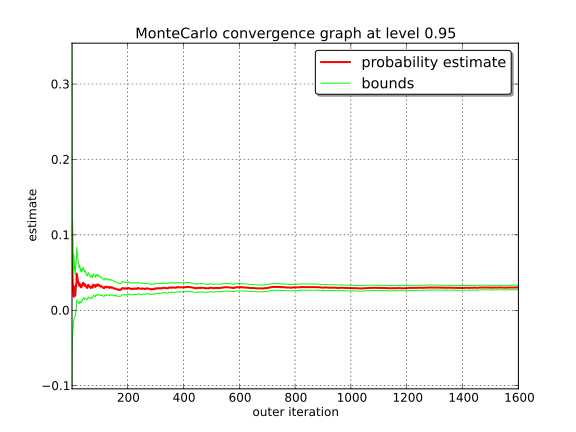

In [23]:
# Using Monte Carlo simulations
cv = 0.05
NbSim = 100000

algoMC = ot.MonteCarlo(myEvent)
algoMC.setMaximumOuterSampling(NbSim)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoMC.run()

# Results:
result = algoMC.getResult()
probability = result.getProbabilityEstimate()
print('MonteCarlo result=', result)
print('Number of executed iterations =', result.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', probability)
print('CV =', result.getCoefficientOfVariation())
algoMC.drawProbabilityConvergence()

Number of calls to the limit state = 98
Pf = 0.0299850318913


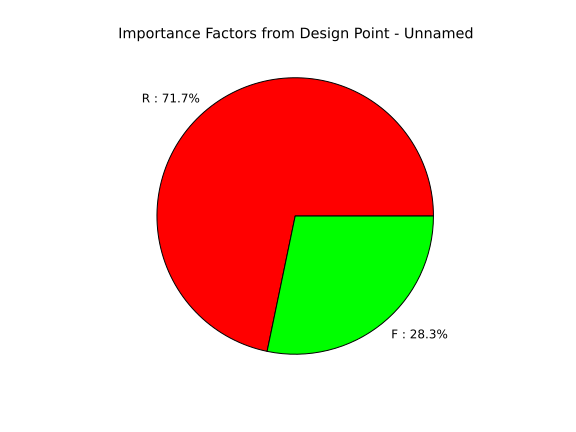

In [24]:
# Using FORM analysis

# We create a NearestPoint algorithm
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
myCobyla.setMaximumIterationsNumber(100)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# We create a FORM algorithm
# The first parameter is a NearestPointAlgorithm
# The second parameter is an event
# The third parameter is a starting point for the design point research

algoFORM = ot.FORM(myCobyla, myEvent, myDistribution.getMean())

# Perform the analysis:
algoFORM.run()

# Results:
result = algoFORM.getResult()
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf =', result.getEventProbability())

# Graphical result output
result.drawImportanceFactors()

Number of executed iterations = 481
Number of calls to the limit state = 8830
Pf =  0.0297305755073
CV = 0.0499171711488


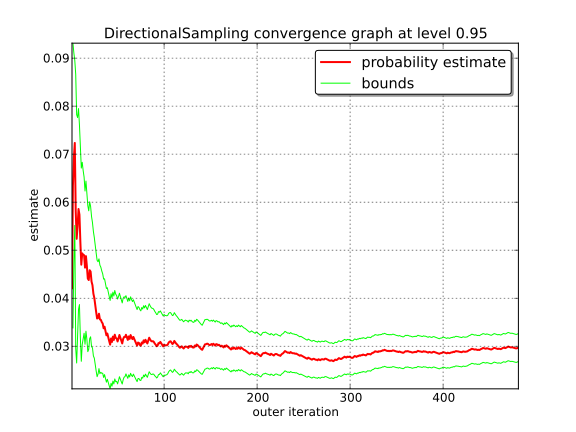

In [25]:
# Using Directional sampling

# Resolution options:
cv = 0.05
NbSim = int(1e5)

algoDS = ot.DirectionalSampling(myEvent)
algoDS.setMaximumOuterSampling(NbSim)
algoDS.setBlockSize(1)
algoDS.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoDS.run()

# Results:
result = algoDS.getResult()
probability = result.getProbabilityEstimate()
print('Number of executed iterations =', result.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', probability)
print('CV =', result.getCoefficientOfVariation())
algoDS.drawProbabilityConvergence()

